# Introduction


### It must be stressed that the ideas contained in this notebook have not gone through rigorous testing and validation. This work was done in a couple of hours. I will not trade it as it is and I do not advise the reader to do so either. There has been some overfitting and bias implicit in the development process. This does not serve as investment advice but as an explorationof a possible opportunity. Enjoy!


In this notebook, I analyse the time series properties of the Litecoin crypto-currency and then proceed to building a predictive model based on my discoveries. I test the efficacy of the predicitve power with a naive trading strategy. I then proceed to improve on this model by adding additional the returns of other crypto-currencies to build a classification based predictive model. I then test this improved model with a similar naive strategy

This notebook is largely of my own creation but consists of code from: 

QuantAtRisk:
(http://www.quantatrisk.com/2017/03/31/cryptocurrency-portfolio-correlation-pca-python/) for web scraping crypto-currency data,

Quantopian Lecture Series:
(https://www.quantopian.com/research/notebooks/Cloned%20from%20%22Autocorrelation%20and%20AR%20Models%22.ipynb) for ACF and PACF correlogram

Machine Learning Mastery:
(https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) for ARMA model implementations.



## Retrieving Crypto-Currency data 
In this part of the notebook pricing data for 21 crypto currencies (including litecoin) are retrieved from cryptocompare using the BeautifulSoup web scraping module.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import json
from bs4 import BeautifulSoup
import requests
 
# define some custom colours
grey = .6, .6, .6
 
useless = 1  #ignore this
def timestamp2date(timestamp):
    # function converts a Unix timestamp into Gregorian date
    return datetime.fromtimestamp(int(timestamp)).strftime('%Y-%m-%d')
 
def date2timestamp(date):
    # function coverts Gregorian date in a given format to timestamp
    return datetime.strptime(date_today, '%Y-%m-%d').timestamp()
 
def fetchCryptoClose(fsym, tsym):
    # function fetches the close-price time-series from cryptocompare.com
    # it may ignore USDT coin (due to near-zero pricing)
    # daily sampled
    cols = ['date', 'timestamp', fsym]
    lst = ['time', 'open', 'high', 'low', 'close']
    timestamp_today = datetime.today().timestamp()
    curr_timestamp = timestamp_today
 
    for j in range(2):
        df = pd.DataFrame(columns=cols)
        url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + fsym + \
              "&tsym=" + tsym + "&toTs=" + str(int(curr_timestamp)) + "&limit=2000"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
        for i in range(1, 2001):
            tmp = []
            for e in enumerate(lst):
                x = e[0]
                y = dic['Data'][i][e[1]]
                if(x == 0):
                    tmp.append(str(timestamp2date(y)))
                tmp.append(y)
            if(np.sum(tmp[-4::]) > 0):  # remove for USDT
                tmp = np.array(tmp)
                tmp = tmp[[0,1,4]]  # filter solely for close prices
                df.loc[len(df)] = np.array(tmp)
        # ensure a correct date format
        df.index = pd.to_datetime(df.date, format="%Y-%m-%d")
        df.drop('date', axis=1, inplace=True)
        curr_timestamp = int(df.ix[0][0])
        if(j == 0):
            df0 = df.copy()
        else:
            data = pd.concat([df, df0], axis=0)
    data.drop("timestamp", axis=1, inplace=True)
 
    return data  # DataFrame

This code block stores the retrieved data in a HDF5 file and then reads it into a pandas dataframe.

In [155]:
# N-Cryptocurrency Portfolio (tickers)
fsym = ['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'LTC', 
        'MAID', 'FCT', 'DGD', 
         'DCR', 'DOGE']
# vs. 
tsym = 'USD'

for e in enumerate(fsym):
    print(e[0], e[1])
    if(e[0] == 0):
        try:
            data = fetchCryptoClose(e[1], tsym)
        except:
            pass
    else:
        try:
            data = data.join(fetchCryptoClose(e[1], tsym))
        except:
            pass
 
useless = 1 #ignore this
data = data.astype(float)  # ensure values to be floats
 
# save portfolio to a file (HDF5 file format)
store = pd.HDFStore('portfolio.h5')
store['data'] = data
store.close()
 
# read in your portfolio from a file
df = pd.read_hdf('portfolio.h5', 'data')
print(len(df))

0 BTC


C:\Users\Olaoluwapo\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1 ETH
2 DASH
3 XMR
4 XRP
5 LTC
6 MAID
7 ZEC
8 FCT
9 DGD
10 DCR
11 DOGE
2971


In [241]:
df = df[['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'LTC', 
        'MAID', 'FCT', 'DGD', 
         'DCR', 'DOGE']]
df = df[:]
df2.head()

,BTC,ETH,DASH,XMR,XRP,LTC,MAID,FCT,DGD,DCR,DOGE
date,,,,,,,,,,,
2015-10-05,236.41,0.6078,2.15,0.3892,0.00444,2.94,0.01845,0.1441,0.001057,0.03242,0.00012
2015-10-05,236.41,0.6078,2.15,0.3892,0.00444,2.94,0.01845,0.1441,0.001057,0.03242,0.00012
2015-10-06,239.36,0.6091,2.38,0.3892,0.00570,2.98,0.01890,0.1625,0.001083,0.03323,0.00012
2015-10-07,241.65,0.6000,2.40,0.3917,0.00550,3.01,0.01883,0.1317,0.001069,0.03280,0.00012
2015-10-08,241.57,0.6000,2.39,0.3785,0.00510,3.00,0.01899,0.1318,0.001067,0.04847,0.00012


In this code block, the dataframe containing crypt currency pricing data is purged of all NaN values to prevent excessive data cleaning and filling of missing data. This is a trade-off between sample size and accuracy. It is also less stressful.

In [167]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, pacf
from pandas import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

df2 = df.dropna()
X = df2['LTC'][:]#resample('W').last().dropna()
X.shape

(1051,)

This code block is used to calculate the autocorrelation and partial autocorrelation coefficients for lag periods from 1 to 20. These will be used to determine if the time series follows an Autoregressive (AR) or a Moving Average (MA) process.

In [96]:
# We'll choose 40 lags. This is a bit arbitrary, but you want to include all the lags you think might
# feasibly impact the current value.
nlags = 20
# Note, this will produce nlags + 1 values, as we include the autocorrelation of
# X[-1] with X[-1], which is trivially 1.
# The reason this is done is because that is the 0th spot in the array and corresponds
# to the 0th lag of X[(-1)-0].
X_acf = acf(X, nlags=nlags)
print('Autocorrelations:\n' + str(X_acf) + '\n')
X_pacf = pacf(X, nlags=nlags)
print('Partial Autocorrelations:\n' + str(X_pacf))

Autocorrelations:
[ 1.          0.98643223  0.97576824  0.96373745  0.95455018  0.94415277
  0.93420471  0.92243258  0.91010804  0.89649399  0.88660991  0.8776913
  0.86708928  0.85714337  0.84794497  0.83936711  0.83008909  0.8223325
  0.81180129  0.80344914  0.79557535]

Partial Autocorrelations:
[ 1.          0.98807903  0.11525465 -0.04995553  0.10354084 -0.0292361
 -0.00527915 -0.06769743 -0.05596774 -0.06446704  0.13198766  0.07274965
 -0.08974139  0.04070613  0.05107852  0.01584496 -0.03947435  0.0436626
 -0.12829466  0.07552817  0.08307508]


Now that the autocorrelation coefficients have been discovered. Correlograms can be plotted to present the findings graphically.
Confidence intervals have also been plotted to prevent statistically insignificant autocorrelations from being perceived as relevant

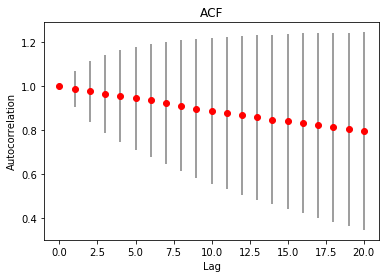

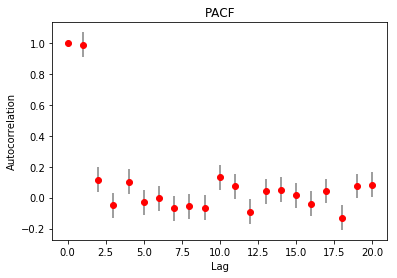

In [97]:
def plot_acf(X_acf, X_acf_confs, title='ACF'):
    # The confidence intervals are returned by the functions as (lower, upper)
    # The plotting function needs them in the form (x-lower, upper-x)
    errorbars = np.ndarray((2, len(X_acf)))
    errorbars[0, :] = X_acf - X_acf_confs[:,0]
    errorbars[1, :] = X_acf_confs[:,1] - X_acf

    plt.plot(X_acf, 'ro')
    plt.errorbar(range(len(X_acf)), X_acf, yerr=errorbars, fmt='none', ecolor='gray', capthick=2)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title);
    
# We have to set a confidence level for our intervals, we choose the standard of 95%,
# corresponding with an alpha of 0.05.
X_acf, X_acf_confs = acf(X, nlags=nlags, alpha=0.05)
X_pacf, X_pacf_confs = pacf(X, nlags=nlags, alpha=0.05)
#plot_acf(X_acf, X_acf_confs)
plt.figure()
plot_acf(X_acf, X_acf_confs, title='ACF')
plt.figure()
plot_acf(X_pacf, X_pacf_confs, title='PACF')

From the graphs above it is clear that the Autocorrelation function is declines geometricallly with increase in lag.
The Partial Autocorrelation function ins significant only for the first two lags.
This indicates that the time series is strongly inclined towrds an Autoregressive model rather than a Moving avarage. 
It also indicates that the order of the Autoregrssive model is 2. 

An autoregressive model and a Moving Average model are then built to test this hypothesis. If it is correct the autoregressive model will have less mean squared error.


In [98]:
#rolling predictions_AR
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions_AR = list()
for t in range(len(test)):
    model = ARIMA(history, order = (5,0,0))
    model_fit_AR = model.fit(disp = False)
    output = model_fit_AR.forecast()
    yhat = output[0]
    predictions_AR.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions_AR)
print('Test MSE: %.3f' % error)

Test MSE: 68.507


In [99]:
#rolling predictions_MA
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions_MA = list()
for t in range(len(test)):
    model = ARIMA(history, order = (0,0,5))
    model_fit_MA = model.fit(disp = False)
    output = model_fit_MA.forecast()
    yhat = output[0]
    predictions_MA.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions_MA)
print('Test MSE: %.3f' % error)

C:\Users\Olaoluwapo\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test MSE: 204.109


The mean squared error of the AR model is 19.582 while that of the MA model is 348.206. This difference is significant. 
Thus, it confirms that for the sample being observed, the underlying time series process is more inclined towards an
Autoregressive process than a Moving Average Process. 
 
The code block below show a statistical analysis of the results of fitting bothe models to the time series data

In [100]:
print(model_fit_AR.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  599
Model:                     ARMA(5, 0)   Log Likelihood               -2270.535
Method:                       css-mle   S.D. of innovations             10.681
Date:                Sat, 18 Aug 2018   AIC                           4555.070
Time:                        11:34:39   BIC                           4585.837
Sample:                             0   HQIC                          4567.048
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.6561     33.746      1.975      0.049       0.515     132.797
ar.L1.y        0.8894      0.041     21.807      0.000       0.809       0.969
ar.L2.y        0.1332      0.054      2.449      0.0

In [101]:
print(model_fit_MA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  599
Model:                     ARMA(0, 5)   Log Likelihood               -2499.555
Method:                       css-mle   S.D. of innovations             15.651
Date:                Sat, 18 Aug 2018   AIC                           5013.110
Time:                        11:34:39   BIC                           5043.877
Sample:                             0   HQIC                          5025.088
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.6193      4.398     17.877      0.000      70.000      87.239
ma.L1.y        1.2916      0.035     36.788      0.000       1.223       1.360
ma.L2.y        1.6403      0.051     32.389      0.0

A plot illustrates the difference in accuracy between the AR model and the MA model. The AR model's prediction closely
follows the results from the actual data generating process, while the MA process loosely follows it.

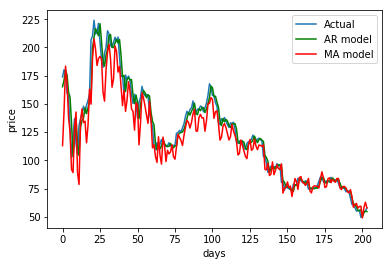

In [102]:
# plot
plt.plot(range(len(test)),test)
plt.plot(range(len(test)),predictions_AR, color='green')
plt.plot(range(len(test)),predictions_MA, color='red')
plt.legend(['Actual', 'AR model', 'MA model'])
plt.ylabel('price')
plt.xlabel('days')

A simple trading startegy is developed to test the feasibility of this model for trding purposes. The trading 
algorithm simply buys when the current price is below the AR prediction (undervalued) for the next day and sells 
when it is above (overvalued). The algo holds a position for a single day and then re-evaluates for the next day. If the AR prediction and the price are the same, the algorithm does nothing.
Transactions costs, stop loss orders, bet sizing, and other factors have not been considered. 

In [103]:
# the trade
profit = np.zeros(len(test)-1)
for i in range(1,len(test)):
    if predictions_AR[i] > test[i-1]:
        profit[i-1] = 1 * (test[i]-test[i-1])/test[i-1]
    if predictions_AR[i] < test[i-1]:
        profit[i-1] = -1 * (test[i]-test[i-1])/test[i-1]
    if predictions_AR[i] == test[i-1]:
        profit[i-1] = 0

profit;

A plot is made to visualize the returns from trading this strategy. Despite the predictive power of the AR model 
(low mean squared error), the trading algorithm loses money. I hypothesize that this is because a good prediction infers
one that is close to the actual value. It does not define whether it is greater than or less than this value. It simply 
implies that it is close. In this case, although predictions are close to the actual value, they repeatedly miss the mark 
in terms of direction. For exmaple,let's say the current price of LTC is 10. Model A's (random name) prediction of tomorrow's price is 11, while model B's prediction is 4. If the tomorrow's price ends up being 9, model A's squared error will be 2 x 2 = 4, while model B's will be 5 x 5 = 25. Clearly, model A is a better predictor of price. 
But a trading algorithm that works by taking a position based on the relative price will have gone long based on model A's prediction, and short based on model B's prediction. Algo A will have lost 2 (11 - 9 = 2) on the trade while ALgo B will have made 1 (10 - 9 = 1) on the trade. Thus ALgo B has the upper hand in such a trade.

In this case, my hypothesis that the AR model often misses the direction of the nect day's move even though it comes very close to the actual price can be tested by calculating the corrrelation coefficient between the actual change in price and the change in price predicted by the AR model. This is done below:

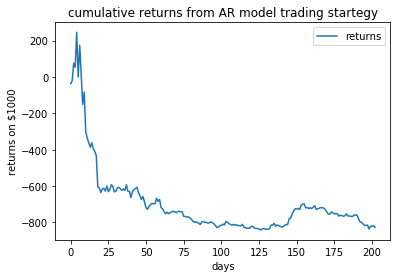

In [104]:
#plt.plot(np.cumsum(profit))
plt.plot((np.cumprod(profit+1)-1)*1000)
plt.legend(['returns'])
plt.xlabel('days')
plt.ylabel('returns on $1000')
plt.title('cumulative returns from AR model trading startegy')

In [107]:
len(predictions_AR)
len(test)
np.array(predictions_AR)
for i in range(len(predictions_AR)):
    predictions_AR[i] = predictions_AR[i][0]
    
len(predictions_AR)

predicted_change= predictions_AR[1:] - test[:-1]
predicted_change = predicted_change[:]
predicted_change = np.array(predicted_change)
print(predicted_change.shape)

actual_change = np.array(test[1:]) - np.array(test[:-1])
actual_change = actual_change[:]
actual_change = np.array(actual_change)
print(actual_change.shape)

np.corrcoef(predicted_change,actual_change)

(203,)
(203,)


array([[ 1.        , -0.14373236],
       [-0.14373236,  1.        ]])

The correlation co-efficient of the predicted change and the actual change is merely 0.23. This means that it is weakly 
correlated and thus explains the poor performance of the trading strategy.

# Alternative Model - Linear Classifiers

In this section I aim to develop an alternative model to outperform the AR model by utilising hsitorical pricing data from other cryptocurrencies as well as LTC. 20 additional crypto-currencies have been added to the fold for this purpose. Their prices will be backdated by a single day to avoid look-ahead bias. LTC past pricing data is also utilised as a feature. For each crypto-currency, only the previous day's pricing data is used to predict the current day's price of LTC. 

Two linear classifiers are used to test this: A logistic regression classifier and a Support Vector Classifier. 
Classifiers are used as opposed to numerical regression because classifiers can be better trained to predict the direction
of change in price. Since the trading strategy does not have a target 'take profit price', there is no advantage to getting a numerical figure for the predicted change in price.

In this code block, the pricing data of the predictors (features) is backdated by a day to avoid look-ahead bias.
The target variable is discretised to {-1,0,1} corresponding to {decrease, none, increase} movement in price.



In [283]:

features_1 = df2 [['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'LTC', 
        'MAID', 'FCT', 'DGD', 
         'DCR', 'DOGE']].pct_change().dropna()[:-2].values
print(len(features_1))

features_2 = df2 [['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'LTC', 
        'MAID', 'FCT', 'DGD', 
         'DCR', 'DOGE']].pct_change().dropna()[1:-1].values
print(len(features_2))


features_1 = pd.DataFrame(features_1)
features_2 = pd.DataFrame(features_2)

features =  pd.concat([features_1, features_2], axis=1)

LTC = df2['LTC'].pct_change()[1:].dropna()[2:]
target = [1  if i > 0 else -1 for i in LTC]
print(len(target))
features.head()


1048
1048
1048


,0,1,2,3,4,5,6,7,8,9,...,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002139,0.106977,0.000000,0.283784,0.013605,0.024390,0.127689,0.024598,0.024985,0.000000
1,0.012478,0.002139,0.106977,0.000000,0.283784,0.013605,0.024390,0.127689,0.024598,0.024985,...,-0.014940,0.008403,0.006423,-0.035088,0.010067,-0.003704,-0.189538,-0.012927,-0.012940,-0.000832
2,0.009567,-0.014940,0.008403,0.006423,-0.035088,0.010067,-0.003704,-0.189538,-0.012927,-0.012940,...,0.000000,-0.004167,-0.033699,-0.072727,-0.003322,0.008497,0.000759,-0.001871,0.477744,0.001665
3,-0.000331,0.000000,-0.004167,-0.033699,-0.072727,-0.003322,0.008497,0.000759,-0.001871,0.477744,...,-0.049833,-0.029289,0.000000,-0.019608,0.010000,0.022643,-0.227618,0.006560,0.005983,-0.042394
4,-0.000952,-0.049833,-0.029289,0.000000,-0.019608,0.010000,0.022643,-0.227618,0.006560,0.005983,...,0.114015,0.000000,0.000000,0.008800,0.006601,0.007209,0.113949,0.005587,0.005332,0.020833


The data is trained and tested on with a Linear Regression model
This gives a 52.43 percent accuracy. This is marginally better than random and very likely to be statistically insignificantly
different from random. The confusion matrix shows that it predicts 


In [284]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

model_LR = LogisticRegression()
model_LR.fit(train_f, train_t)
predictions = model_LR.predict(test_f)
predictions = list(predictions)
#print(predictions)
#print(test_t)


conf = confusion_matrix(test_t, predictions)
conf_sum = np.sum(np.sum(conf, axis= 1))
perc_correct = (conf[0,0] + conf[1,1])/ conf_sum

print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(perc_correct * 100))

the confusion matrix: 
 [[ 18 152]
 [ 14 171]]

the proportion of correct predictions: 53.2394 percent


The data is trained and tested on with a Suppor Vector Classifier model
This gives a 40.77 percent accuracy. This is marginally worse than random and very likely to be statistically insignificantly
different from random. The confusion matrix shows that it predicts all returns to be positive (There is a name for 
this kind of trivial behaviour by a classifier but I cant remember right now). This is probably due to a predominance of 
positive returns in the training data.


In [285]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

model_SVC = SVC()
model_SVC.fit(train_f, train_t)
predictions_SVC = model_SVC.predict(test_f)
predictions_SVC = list(predictions_SVC)
#print(predictions_SVC)
#print(test_t)

conf = confusion_matrix(test_t, predictions_SVC)
conf_sum = np.sum(np.sum(conf, axis= 1))
perc_correct = (conf[0,0] + conf[1,1])/ conf_sum

print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(perc_correct * 100))

the confusion matrix: 
 [[  0 170]
 [  0 185]]

the proportion of correct predictions: 52.1127 percent


In order to improve on the model, a PCA reduction with whitening is carried out on the features. This reduces the 
dimensionality of the data and thus prevents unwanted properties such a multicollinearity. A simple way to think of this
is that it combines correlated features in order to produce a single one that accounts for them. In essence, I have reduced the dimensionality of the features from 21 to 15 while retainig most of the information available in the 21 and also making the odel less prone to errors caused by having redundant features. 


The application of PCA reduction prior to applying a Logistic Regression Classifier has significantly improved its performance.Now it has an accuracy rate of 70 percent and a more balanced confusion matrix (indicating less bias towards aparticular class in the model's decisions)

Note: The choice of 15 components was settled on after some manual local search optimization (trial and error). Although this could actually be optimised via convex optimization, brute force search, or visually.

In [291]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn.pipeline

size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

pipe = Pipeline([('pca', PCA(n_components=15, whiten=True)),
                      ('regr',LogisticRegression())])

pipe.fit(train_f, train_t)
predictions_pipe_LR = pipe.predict(test_f)
conf = confusion_matrix(test_t, predictions_pipe_LR)
conf_sum = np.sum(np.sum(conf, axis= 1))
perc_correct = (conf[0,0] + conf[1,1])/ conf_sum
print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(perc_correct * 100))

the confusion matrix: 
 [[ 20 150]
 [ 14 171]]

the proportion of correct predictions: 53.8028 percent


Similar to the results of the PCA-LogisticRegresion model, the application of PCA reduction prior to applying a Suppoert Vector Classifier has significantly improved its performance.Now it has an accuracy rate of 70 percent and a much more balanced confusion matrix (eliminating the bias towards the positve class notice previously)

Observation:- The results of the LR and SVC model seem very similar for this test sample

In [292]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn.pipeline

size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

pipe = Pipeline([('pca', PCA(n_components=15, whiten=True)),
                      ('regr',SVC())])

pipe.fit(train_f, train_t)
predictions_pipe_SVC = pipe.predict(test_f)
conf = confusion_matrix(test_t, predictions_pipe_SVC)
conf_sum = np.sum(np.sum(conf, axis= 1))
perc_correct = (conf[0,0] + conf[1,1])/ conf_sum
print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(perc_correct * 100))


the confusion matrix: 
 [[  2 168]
 [  2 183]]

the proportion of correct predictions: 52.1127 percent


The same traidng strategy is constructed for the PCA-LR and PCA-SVC models as used with the AR model. The only difference is that this is coded up in a vecotrised manner as it was most convenient since the classes {-1, 0, 1} also represent the next day decision {sell, none, buy}. 

The returns of bothe strategies are plotted below.

Note: The AR trading stategy could have been coded in a vectrised manner but wasn't for transparency sake.

In [237]:
profit_LR = predictions_pipe_LR * LTC[size:len(X)]
profit_SVC = predictions_pipe_SVC * LTC[size:len(X)]

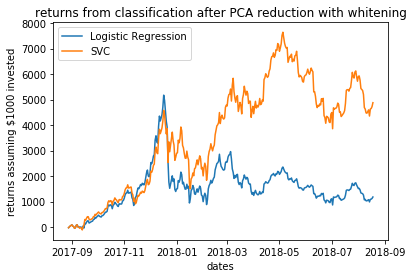

In [238]:
plt.plot((np.cumprod(profit_LR+1)-1)*1000)
plt.plot((np.cumprod(profit_SVC+1)-1)*1000)
plt.legend(['Logistic Regression', 'SVC'])
plt.title('returns from classification after PCA reduction with whitening')
plt.xlabel('dates')
plt.ylabel('returns assuming $1000 invested')

The results show that both strategies are profitable but do not give the exact same trades. The value at risk of the strategies have been compyted below. They are probably inaccurate as the distributuons are not normal as shown in the poor fit to the normal distribution corresponding to their mean and standard deviation respectively.

the expected daily return is: 0.0055
the standard deviation measured daily is: 0.0590
the 95-pct confidence daily Value-at-Risk is: -0.1124


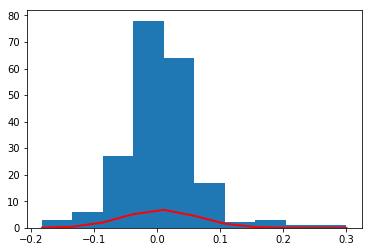

In [140]:
count, bins,_= plt.hist(profit_LR)
mu = profit_LR .mean(axis = 0)
sigma = profit_LR.std(axis = 0)

var95 = (mu - 2* sigma)
#print(type(mu))

print('the expected daily return is: %.4f'%(mu))
print('the standard deviation measured daily is: %.4f'%(sigma))
print('the 95-pct confidence daily Value-at-Risk is: %.4f'%(var95))

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')


the expected daily return is: 0.0110
the standard deviation measured daily is: 0.0582
the 95-pct confidence daily Value-at-Risk is: -0.1055


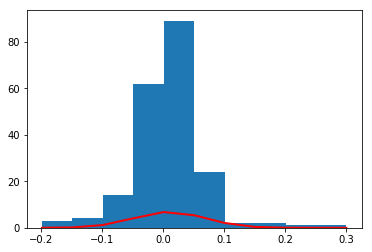

In [158]:
count, bins,_= plt.hist(profit_SVC)
mu = profit_SVC .mean(axis = 0)
sigma = profit_SVC.std(axis = 0)

var95 = (mu - 2* sigma)
#print(type(mu))

print('the expected daily return is: %.4f'%(mu))
print('the standard deviation measured daily is: %.4f'%(sigma))
print('the 95-pct confidence daily Value-at-Risk is: %.4f'%(var95))

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')


# Suggestions for improvement
1. Test predictive power on larger sample space
2. Use bagging to make up for small sample space and reduce over fitting
3. Try more classifiers e.g random forests, etc
4. Try VAR and VEC time series models on a basket of crypto currencies
5. Remove young crypto-currencies so as to enlarge the sample space for more robust testing
6. Try more diverse trading strategies e.g longer holding period, stop loss, take profit, etc
7. Include considerations of (6) in training the ML model and not just in implementing the trading strategy
8. Meta-Strategy Ensemble: Use one ML model to predict when trading strategy will be accurate or not
9. Include sentiment data e.g twitter, news, etc for target coin
10. Consider bet sizing by probabilities derived by classifiers
11. Include transactions cost
12. Many more than I am willing to type in. Use your creativity. But use it with caution
13. Get someone to check for reproducibility